This notebook is a later iteration on some initial exploration. The goal here is to work up a set of items in the GeoKB that represent the mineral species or mineral groups that are important in our mineral resource assessment work and are referenced from data sources on mineral deposits/occurrences. There are likely other mineral species that will need to be added over time as we link with additional domains from the USGS portfolio.

The approach here starts with the USGS Mineral Resource Data System (MRDS) and the unique material names from either ore or gangue in MRDS occurrence records. This was identified as a useful starting point by USGS assessment geologists. We then work to establish linkages from these names to the Geoscience Ontology and Mindat where we gain useful context to establish items in the GeoKB within the overall classification scheme and a couple of specific characteristics useful in queries we need to be able to run.

In [1]:
import pandas as pd
import numpy as np
import rdflib
from glob import glob
from wbmaker import WikibaseConnection

In [222]:
import pygraphviz as pgv
import networkx as nx
import matplotlib.pyplot as plt


# Context for Mineral Material
In setting up this aspect of the GeoKB ontology, I tried to blend both an approach that connects these concepts into the Wikidata world and the approach used in the GSO based on common core ontologies. The former might make more logical sense to the average person while the latter is more philosophically conformant with scientific ontologies across disciplines. The following cell pulls the logical hierarchy from mineral material up through entity and displays it using networkx and graphviz.

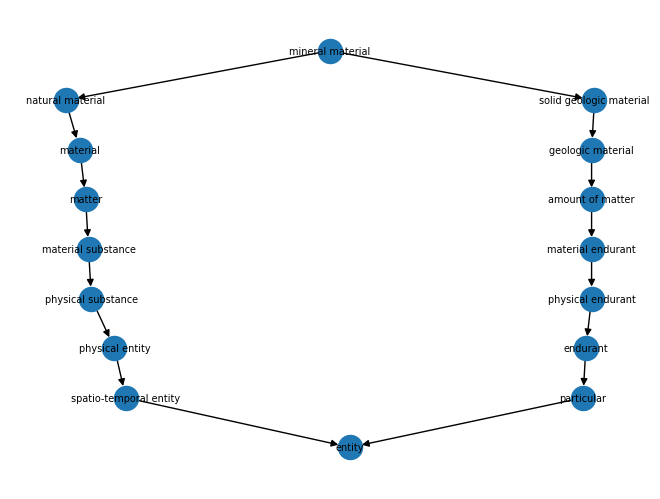

In [235]:
q_mineral_context = """
PREFIX wdt: <https://geokb.wikibase.cloud/prop/direct/>
PREFIX wd: <https://geokb.wikibase.cloud/entity/>

SELECT ?item ?itemLabel ?subclass_of ?subclass_ofLabel
WHERE {
  wd:Q24 wdt:P2* ?item .
  ?item wdt:P2 ?subclass_of .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" . }
}
"""

mineral_context = geokb.sparql_query(q_mineral_context)

G = nx.DiGraph()

for _, row in mineral_context.iterrows():
    G.add_edge(row['itemLabel'], row['subclass_ofLabel'])

pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')

nx.draw(G, pos, with_labels=False)
labels = nx.draw_networkx_labels(G, pos, font_size=7)

plt.show()

# MRDS Mineral/Commondity Names and Codes
There are a number of ways to get MRDS data. I ended up downloading the full set of tables and pulling the Materials table for this purpose. The live WFS service might be better, but I didn't feel like dealing with the geometry as GML for simply getting the unique material names to work through.

In [2]:
mrds_materials = pd.read_csv('../data/Materials.txt', sep='\t')
mrds_material_names = mrds_materials[mrds_materials['ore_gangue'].isin(['Ore','Gangue'])]['material'].unique()
sorted(mrds_material_names)

['Abernathyite',
 'Acanthite',
 'Acmite',
 'Actinolite',
 'Adamite',
 'Adularia',
 'Aegirine',
 'Agate',
 'Aguilarite',
 'Aikinite',
 'Alabandite',
 'Alabaster',
 'Albite',
 'Alexandrite',
 'Algodonite',
 'Allanite',
 'Alloclasite',
 'Allophane',
 'Almandine',
 'Almandite',
 'Altaite',
 'Alunite',
 'Amalgam',
 'Amazonstone',
 'Amblygonite',
 'Amethyst',
 'Amphibole',
 'Amphibolite',
 'Analcime',
 'Anatase',
 'Anauxite',
 'Ancylite',
 'Andalusite',
 'Andesine',
 'Andesite',
 'Andorite',
 'Andradite',
 'Anglesite',
 'Anhydrite',
 'Anilite',
 'Ankerite',
 'Annabergite',
 'Anorthite',
 'Anorthosite',
 'Anthophyllite',
 'Antigorite',
 'Antimony',
 'Antlerite',
 'Apatite',
 'Apophyllite',
 'Aquamarine',
 'Aragonite',
 'Aramayoite',
 'Argentite',
 'Argentojarosite',
 'Arsenbrackebuschite',
 'Arsenic',
 'Arsenical Copper',
 'Arsenolite',
 'Arsenopyrite',
 'Arsenuranylite',
 'Asbestos',
 'Ash',
 'Astrophyllite',
 'Atacamite',
 'Attapulgite',
 'Augite',
 'Aurichalcite',
 'Aurorite',
 'Autunite',

# Mindat Minerals

In [3]:
# Pull from cache for now; may revisit this live with Mindat API at some point
import pickle
mindat_items = pickle.load(open('../data/mindat_items_20230420.p', 'rb'))

In [5]:
mindat_properties = [
    'id',
    'name',
    'entrytype_text',
    'synid',
    'varietyof',
    'groupid',
    'description_short',
    'elements',
    'ima_formula',
    'strunz10ed1',
    'strunz10ed2',
    'strunz10ed3',
    'strunz10ed4'
]

mindat = mindat_items[mindat_properties].drop_duplicates(subset='name').reset_index(drop=True)

# Make a few tweaks so we can do other work with this data
mindat['mindatid'] = mindat['id'].apply(lambda x: f'min-{x}')
mindat['mindaturl'] = mindat['id'].apply(lambda x: f'http://www.mindat.org/min-{x}.html')
mindat['elements'] = mindat['elements'].apply(lambda x: [i.strip() for i in x.split('-') if len(i.strip()) > 0])
mindat_properties = mindat_properties + ['mindatid', 'mindaturl']

# Move synonym names to a list on their preferred item
# This eliminates many items from our set but retains the aspect we need for this exercise
mindat = pd.merge(
    left=mindat[mindat['synid'] == 0].drop(columns=['synid']),
    right=mindat[mindat['synid'] > 0][['synid','name']].groupby('synid', as_index=False).agg(list).rename(columns={'synid': 'id', 'name': 'synonyms'}),
    how='left',
    on='id'
).reset_index(drop=True)

# Concatenate Strunz IDs
def strunz_mindat(x):
    strunz_id = ''
    if x['strunz10ed1'].isdigit():
        if int(x['strunz10ed1']) < 10:
            strunz_id += f'0{x["strunz10ed1"]}'
        else:
            strunz_id += str(x['strunz10ed1'])
        if len(x['strunz10ed2']) > 0:
            strunz_id += f'.{x["strunz10ed2"]}'
        if len(x['strunz10ed3']) > 0:
            strunz_id += f'{x["strunz10ed3"]}'
        if len(x['strunz10ed4']) > 0:
            strunz_id += f'.{x["strunz10ed4"]}'

        if len(strunz_id) > 0 and not strunz_id.startswith('00'):
            return strunz_id
        else:
            return None

mindat['strunz_mindat'] = mindat.apply(strunz_mindat, axis=1)
mindat.drop(columns=['strunz10ed1', 'strunz10ed2', 'strunz10ed3', 'strunz10ed4'], inplace=True)

# Group varieties for has variety property
mindat['varietyof'] = mindat['varietyof'].apply(lambda x: x if str(x).isdigit() else 0)
mindat = pd.merge(
    left=mindat,
    right=mindat[mindat['varietyof'] > 0][['varietyof','id']].groupby('varietyof', as_index=False).agg(list).rename(columns={'varietyof': 'id', 'id': 'varieties'}),
    how='left',
    on='id'
)

# Group members for has member property
mindat = pd.merge(
    left=mindat,
    right=mindat[mindat['groupid'] > 0][['groupid','id']].groupby('groupid', as_index=False).agg(list).rename(columns={'groupid': 'id', 'id': 'members'}),
    how='left',
    on='id'
)
mindat.rename(columns={'groupid': 'memberof'}, inplace=True)

# MRDS Name Alignment

In [6]:
mindat_names = mindat[['id','name']].reset_index(drop=True).rename(columns={'name': 'label'})
mindat_names['label_type'] = 'preferred'
mindat_synonyms = mindat[['id','synonyms']].explode('synonyms').dropna().reset_index(drop=True).rename(columns={'synonyms': 'label'})
mindat_synonyms['label_type'] = 'synonym'

mindat_name_reference = pd.concat([mindat_names, mindat_synonyms], ignore_index=True)

In [7]:
# Fill MRDS name
mrds_variant_names = {
    'Lorandite': 'Lorándite',
    'Amazonstone': 'Amazonite',
    'Ottrelite': 'Ottrélite',
    'Lapis-lazuli': 'Lapis lazuli',
    'Lapis-Lazuli': 'Lapis lazuli',
    'Bastnasite': 'Bastnäsite',
    'Lollingite': 'Löllingite',
    'Rancieite': 'Ranciéite',
    'Nagyagite': 'Nagyágite',
    'Blodite': 'Blödite',
    'Patronite': 'Patrónite',
    'Nickel Skutterudite': 'Nickelskutterudite',
    'Guerinite': 'Guérinite',
    'Schrockingerite': 'Schröckingerite'
}

def mrds_name(mindat_name):
    exact_match = next((i for i in mrds_material_names if i == mindat_name), None)
    if exact_match:
        return exact_match
    
    lower_match = next((i for i in mrds_material_names if i.lower() == mindat_name.lower()), None)
    if lower_match:
        return lower_match
    
    variant_match = next((k for k,v in mrds_variant_names.items() if v == mindat_name), None)
    if variant_match:
        return variant_match
    
    return

mindat_name_reference['mrds_name'] = mindat_name_reference['label'].apply(mrds_name)


In [8]:
# Subset Mindat items to those that have alignment or touch points with MRDS names
direct_mindat_mrds_ids = list(mindat_name_reference[mindat_name_reference['mrds_name'].notna()]['id'].unique())
direct_mrds_mindat_items = mindat[mindat['id'].isin(direct_mindat_mrds_ids)].reset_index(drop=True)
mrds_mindat = pd.concat([
    direct_mrds_mindat_items,
    mindat[mindat['id'].isin(direct_mrds_mindat_items['varietyof'])].reset_index(drop=True),
    mindat[mindat['id'].isin(direct_mrds_mindat_items['memberof'])].reset_index(drop=True),
]).drop_duplicates(subset='id').reset_index(drop=True)

mrds_mindat.head(10)


,id,name,entrytype_text,varietyof,memberof,description_short,elements,ima_formula,mindatid,mindaturl,synonyms,strunz_mindat,varieties,members
0,3,Abernathyite,mineral,0,29311,Meta-autunite Group. Chemically the As analogu...,"[As, O, K, H, U]",K(UO<sub>2</sub>)(AsO<sub>4</sub>) &middot; 3H...,min-3,http://www.mindat.org/min-3.html,"[Abernatyt, Abernathyita, Абернатиит, Abernath...",08.EB.15,NaN,NaN
1,10,Acanthite,mineral,0,46605,Acanthite is the low-temperature modification ...,"[Ag, S]",Ag<sub>2</sub>S,min-10,http://www.mindat.org/min-10.html,"[Akanthite, Beta-Argentite, Para-Silberglanz, ...",02.BA.35,[10270],NaN
2,18,Actinolite,mineral,0,52952,Actinolite is an intermediate member Actinoli...,"[Ca, Fe, Mg, Si, O, H]",&#9723;Ca<sub>2</sub>(Mg<sub>4.5-2.5</sub>Fe<s...,min-18,http://www.mindat.org/min-18.html,"[Actinote, Actynolin, Actynolite, Stralite, St...",09.DE.10,"[11016, 470673]",NaN
3,21,Adamite,mineral,0,32261,Olivenite Group. Adamite-Olivenite Series. \r\...,"[As, Zn, O, H]",Zn<sub>2</sub>(AsO<sub>4</sub>)(OH),min-21,http://www.mindat.org/min-21.html,"[Adamite (of Friedel), Adamine, Adamit, Adamit...",08.BB.30,"[1174, 7437, 8107, 10816, 10910]",NaN
4,28,Adularia,variety,9581,0,A more ordered low-temperature variety of Orth...,"[Al, Si, O, K]",,min-28,http://www.mindat.org/min-28.html,"[Adulaire, Adular, Adulare, Adulaari, Адуляр, ...",None,"[528, 4134]",NaN
5,31,Aegirine,mineral,0,7630,Pyroxene Group. Clinopyroxene Subgroup.\r\nBot...,"[Fe, Na, Si, O]",NaFe<sup>3+</sup>Si<sub>2</sub>O<sub>6</sub>,min-31,http://www.mindat.org/min-31.html,"[Acmite, Achmit, Aegirite, Agerit, Ägirin, Aeg...",09.DA.25,"[4142, 10142, 40332]",NaN
6,40,Aeschynite,mineral,0,0,"A group of rare-earth, titanium, rarely niobiu...",[],,min-40,http://www.mindat.org/min-40.html,"[Eschynite, Eschinite, Aschynite, Aechynite, Ä...",None,[8079],NaN
7,51,Agate,variety,960,0,A distinctly banded fibrous chalcedony. Origin...,[],,min-51,http://www.mindat.org/min-51.html,"[Achates, Achat, Achates vix pellucida, nebulo...",None,"[52, 699, 1790, 2736, 2999, 7592, 7593, 7594, ...",NaN
8,59,Aguilarite,mineral,0,46605,There appear to be two solid solution series i...,"[Ag, Se, S]",Ag<sub>4</sub>SeS,min-59,http://www.mindat.org/min-59.html,"[Aguilarit, Aguilarita, Agvilarīts, Aguilariet...",02.BA.55,NaN,NaN
9,63,Aikinite,mineral,0,0,Aikinite-Bismuthinite Series.\r\n\r\nCompare s...,"[Bi, Cu, Pb, S]",CuPbBiS<sub>3</sub>,min-63,http://www.mindat.org/min-63.html,"[Aikinite (of Chapman), Belonite (of Glocker),...",02.HB.05a,[327],NaN


## Missing MRDS Material Names

In [216]:
[i for i in mrds_material_names if i not in mindat_name_reference['mrds_name'].to_list()]

Cinders
Telluride
Manganese Ox-Hydrous
Titaniferous Magnetitite
Sand and Gravel
Brine
Polycrase
Stetefeldite
Iron Oxides-Hydrated
Amalgam
Tripoli
Geodes
Potash
Oyster Shells
Schorlite
Hausmanite
Carnalite
Thalenite
Lapis-Lazuli
Vanadiferous Magnetite
Mineral Paint
Fullers Earth
Tyunjamunite
Mineral Pigments
Yttrialite
Vordisite
Fersmannite
Verde Antique


# Connect to GeoKB

In [179]:
geokb = WikibaseConnection('GEOKB_CLOUD')

# Existing Mindat

In [11]:
q_existing_mindat = """
PREFIX wdt: <https://geokb.wikibase.cloud/prop/direct/>

SELECT ?item ?itemLabel ?itemAltLabel ?same_as
WHERE {
  ?item wdt:P84 ?same_as .
  FILTER (CONTAINS(STR(?same_as), 'mindat.org/min-'))
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" . }
}
"""

geokb_mindat = geokb.sparql_query(q_existing_mindat)
geokb_mindat['qid'] = geokb_mindat['item'].apply(lambda x: x.split('/')[-1])
geokb_mindat['mindatid'] = geokb_mindat['same_as'].apply(lambda x: x.split('/')[-1].split('.')[0])

geokb_mindat.head()

,item,itemLabel,itemAltLabel,same_as,qid,mindatid
0,https://geokb.wikibase.cloud/entity/Q41405,bright-coal,None,https://mindat.org/min-49317.html,Q41405,min-49317
1,https://geokb.wikibase.cloud/entity/Q41414,asphaltic sandstone,None,https://mindat.org/min-50763.html,Q41414,min-50763
2,https://geokb.wikibase.cloud/entity/Q41415,argulite,None,https://mindat.org/min-50764.html,Q41415,min-50764
3,https://geokb.wikibase.cloud/entity/Q41418,predazzite,None,https://mindat.org/min-30656.html,Q41418,min-30656
4,https://geokb.wikibase.cloud/entity/Q41420,pencatite,None,https://mindat.org/min-30657.html,Q41420,min-30657


In [12]:
mindat_mrds_geokb = pd.merge(
    left=mrds_mindat,
    right=geokb_mindat[['mindatid','qid','itemLabel','itemAltLabel']],
    how='left',
    on='mindatid'
)

mindat_mrds_geokb[mindat_mrds_geokb['qid'].notnull()]

,id,name,entrytype_text,varietyof,memberof,description_short,elements,ima_formula,mindatid,mindaturl,synonyms,strunz_mindat,varieties,members,qid,itemLabel,itemAltLabel
62,575,Bauxite,rock,0,0,Predominantly hydrated aluminium oxides with i...,[],,min-575,http://www.mindat.org/min-575.html,"[Alcrete, Beauxite, Bauxit, Bauxita, Beauxit, ...",None,NaN,NaN,Q41276,bauxite,None
127,994,Chert,rock,0,0,"A dense, hard, fine grained, siliceous-rock wi...",[],,min-994,http://www.mindat.org/min-994.html,"[Mozarkit, Rohovec, Hornstone, 硅质岩, Seirt]",None,"[9859, 27263]",NaN,Q41282,chert,None
128,49404,Gravel,rock,0,0,A gravel-grade clastic-sediment.\r\ni. An unco...,[],,min-49404,http://www.mindat.org/min-49404.html,[Gravel-grade-sediment],None,NaN,NaN,Q41309,gravel,None
141,49436,Conglomerate,rock,0,0,A gravel-grade clastic-sedimentary-rock.\r\nA ...,[],,min-49436,http://www.mindat.org/min-49436.html,"[Gravel-grade-sedimentary-rock, Conglomérat, C...",None,NaN,NaN,Q41318,conglomerate,None
312,2330,Lapis lazuli,rock,0,0,An uncommon metamorphic rock having lazurite a...,[],,min-2330,http://www.mindat.org/min-2330.html,"[Lazuritite, 青金石]",None,"[26492, 39173]",NaN,Q41324,lapis lazuli,lapis-lazuli
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,49448,Siltstone,rock,0,0,A mudstone with silt-grade clasts. An indurate...,[],,min-49448,http://www.mindat.org/min-49448.html,"[Siltite, Aleurolite]",None,NaN,NaN,Q42591,siltstone,None
701,50064,Phyllite,rock,0,0,A fine to medium-grained metamorphic rock char...,[],,min-50064,http://www.mindat.org/min-50064.html,[Phyllades],None,NaN,NaN,Q43036,phyllite,None
703,50473,Spessartite,rock,0,0,A lampropyre with plagioclase>K-feldspar and h...,[],,min-50473,http://www.mindat.org/min-50473.html,[Spessartite-rock],None,[54625],NaN,Q43199,spessartite,None
704,50966,Soil,rock,0,0,i. All unconsolidated materials above bedrock....,[],,min-50966,http://www.mindat.org/min-50966.html,NaN,None,NaN,NaN,Q43459,soil,None


# Geoscience Ontology Minerals

In [ ]:
gso_gsmin = rdflib.Graph()
gso_gsmin.parse(
    'https://raw.githubusercontent.com/Loop3D/GKM/master/Loop3D-GSO/Modules/GSO-Geologic_Mineral.ttl',
    format='turtle'
)

In [14]:
def aggregator(x):
    value_list = list(set(x.dropna()))
    if len(value_list) == 0:
        return None
    elif len(value_list)  == 1:
        return value_list[0]
    else:
        return value_list

query_gso_minerals = """
SELECT ?iri
?gso_label ?rruffnameplain 
?subclass_of
?rruffchemistry
?strunzcodeV10 ?strunzlabel
?mindatid ?handbookofmineralogyurl ?webmineralurl
?statusnotes
WHERE {
    ?iri rdf:type owl:Class ;
         rdfs:label ?gso_label .
    OPTIONAL { ?iri rdfs:subClassOf ?subclass_of . }
    OPTIONAL { ?iri gsmin:rruffnameplain ?rruffnameplain . }
    OPTIONAL { ?iri gsmin:rruffchemistry ?rruffchemistry . }
    OPTIONAL { ?iri gsmin:strunzlabel ?strunzlabel . }
    OPTIONAL { ?iri gsmin:strunzcodeV10 ?strunzcodeV10 . }
    OPTIONAL { ?iri gsmin:mindatid ?mindatid . }
    OPTIONAL { ?iri gsmin:handbookofmineralogyurl ?handbookofmineralogyurl . }
    OPTIONAL { ?iri gsmin:webmineralurl ?webmineralurl . }
    OPTIONAL { ?iri gsmin:statusnotes ?statusnotes . }
}
"""

gso_minerals = geokb.df_from_graph(gso_gsmin.query(query_gso_minerals))
gso_minerals = gso_minerals.groupby('iri', as_index=False).agg(aggregator)
gso_minerals = gso_minerals.convert_dtypes()
gso_minerals.head()


,iri,gso_label,rruffnameplain,subclass_of,rruffchemistry,strunzcodeV10,strunzlabel,mindatid,handbookofmineralogyurl,webmineralurl,statusnotes
0,https://w3id.org/gso/mineral/abellaite,Abellaite,Abellaite,https://w3id.org/gso/geology/Mineral_Material,NaPb<sup>2+</sup><sub>2</sub>(CO<sub>3</sub>)<...,None,None,min-47008,None,None,"Ibáñez-Insa J, Elvira J J, Llovet X, Pérez-Can..."
1,https://w3id.org/gso/mineral/abelsonite,Abelsonite,Abelsonite,https://w3id.org/gso/geology/Mineral_Material,Ni<sup>2+</sup>C<sub>31</sub>H<sub>32</sub>N<s...,10.CA.20,Miscellaneous Organic Mineral,min-1,http://www.handbookofmineralogy.com/pdfs/abels...,http://www.webmineral.com/data/Abelsonite.shtml,"Milton C, Dwornik E J, Estep-Barnes P A, Finke..."
2,https://w3id.org/gso/mineral/abenakiite-ce,Abenakiite-(Ce),Abenakiite-(Ce),https://w3id.org/gso/geology/Mineral_Material,Na<sub>26</sub>Ce<sup>3+</sup><sub>6</sub>(SiO...,09.CK.10,Cyclosilicate: [Si6O18]12- 6-membered single r...,min-2,None,http://www.webmineral.com/data/Abenakiite-%28C...,"McDonald A M, Chao G Y, Grice J D (1994) Abena..."
3,https://w3id.org/gso/mineral/abernathyite,Abernathyite,Abernathyite,https://w3id.org/gso/geology/Mineral_Material,K(U<sup>6+</sup>O<sub>2</sub>)As<sup>5+</sup>O...,08.EB.15,"Uranyl phosphate or arsenate, UO2:RO4 = 1:1",min-3,http://www.handbookofmineralogy.com/pdfs/abern...,http://www.webmineral.com/data/Abernathyite.shtml,"Thompson M E, Ingram B, Gross E B (1956) Abern..."
4,https://w3id.org/gso/mineral/abhurite,Abhurite,Abhurite,https://w3id.org/gso/geology/Mineral_Material,Sn<sup>2+</sup><sub>21</sub>O<sub>6</sub>(OH)<...,03.DA.30,"Double-, Oxy- or Hydroxy- halide with Cu, etc....",min-4,http://www.handbookofmineralogy.com/pdfs/abhur...,http://www.webmineral.com/data/Abhurite.shtml,"Matzko J J, Evans H T, Mrose M E, Aruscavage P..."


## Add GSO attributes

In [15]:
mindat_mrds_geokb_gso = pd.merge(
    left=mindat_mrds_geokb,
    right=gso_minerals,
    how='left',
    on='mindatid'
)

mindat_mrds_geokb_gso.head()

,id,name,entrytype_text,varietyof,memberof,description_short,elements,ima_formula,mindatid,mindaturl,...,iri,gso_label,rruffnameplain,subclass_of,rruffchemistry,strunzcodeV10,strunzlabel,handbookofmineralogyurl,webmineralurl,statusnotes
0,3,Abernathyite,mineral,0,29311,Meta-autunite Group. Chemically the As analogu...,"[As, O, K, H, U]",K(UO<sub>2</sub>)(AsO<sub>4</sub>) &middot; 3H...,min-3,http://www.mindat.org/min-3.html,...,https://w3id.org/gso/mineral/abernathyite,Abernathyite,Abernathyite,https://w3id.org/gso/geology/Mineral_Material,K(U<sup>6+</sup>O<sub>2</sub>)As<sup>5+</sup>O...,08.EB.15,"Uranyl phosphate or arsenate, UO2:RO4 = 1:1",http://www.handbookofmineralogy.com/pdfs/abern...,http://www.webmineral.com/data/Abernathyite.shtml,"Thompson M E, Ingram B, Gross E B (1956) Abern..."
1,10,Acanthite,mineral,0,46605,Acanthite is the low-temperature modification ...,"[Ag, S]",Ag<sub>2</sub>S,min-10,http://www.mindat.org/min-10.html,...,https://w3id.org/gso/mineral/acanthite,Acanthite,Acanthite,https://w3id.org/gso/geology/Mineral_Material,Ag<sup>1+</sup><sub>2</sub>S<sup>2-</sup>,02.BA.35,"Metal sulfide M:S > 1:1 with Cu, Ag, Au",http://www.handbookofmineralogy.com/pdfs/acant...,http://www.webmineral.com/data/Acanthite.shtml,"Kenngott A (1855) Ueber den akanthit, eine neu..."
2,18,Actinolite,mineral,0,52952,Actinolite is an intermediate member Actinoli...,"[Ca, Fe, Mg, Si, O, H]",&#9723;Ca<sub>2</sub>(Mg<sub>4.5-2.5</sub>Fe<s...,min-18,http://www.mindat.org/min-18.html,...,https://w3id.org/gso/mineral/actinolite,Actinolite,Actinolite,https://w3id.org/gso/geology/Mineral_Material,Ca<sub>2</sub>(Mg<sub>4.5-2.5</sub>Fe<sup>2+</...,09.DE.10,"Inosilicate with 2-periodic double chains, Si4...",http://www.handbookofmineralogy.com/pdfs/actin...,http://www.webmineral.com/data/Actinolite.shtml,Originally named actynolite: Kirwan R (1794) 1...
3,21,Adamite,mineral,0,32261,Olivenite Group. Adamite-Olivenite Series. \r\...,"[As, Zn, O, H]",Zn<sub>2</sub>(AsO<sub>4</sub>)(OH),min-21,http://www.mindat.org/min-21.html,...,https://w3id.org/gso/mineral/adamite,Adamite,Adamite,https://w3id.org/gso/geology/Mineral_Material,Zn<sup>2+</sup><sub>2</sub>As<sup>5+</sup>O<su...,08.BB.30,"Phosphate, etc. with additional anions, withou...",http://www.handbookofmineralogy.com/pdfs/adami...,http://www.webmineral.com/data/Adamite.shtml,"Friedel C, Daubrée G A (1866) Sur l‘adamine, n..."
4,28,Adularia,variety,9581,0,A more ordered low-temperature variety of Orth...,"[Al, Si, O, K]",,min-28,http://www.mindat.org/min-28.html,...,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


# Nickel-Strunz Classification
Both Mindat and GSO have information on the classification of minerals according to the Nickel-Strunz Version 10 methods. In discussions with USGS geologists, it was deemed useful to include the ability to query/filter on the Strunz classification. There is some disagreement between Mindat and GSO beyond the encoding, and I opted to use the intersection between the two and only include those in agreement for now (which is the majority). In separate work, I introduced the higher level class and two orders of subclasses under a special subclass of mineral material, indicating items that are classified in the Nickel-Strunz system. Here, we need to introduce the lowest-level of the classification scheme which will include multiple mineral species in some cases to have the codes and labels in the GeoKB to link with and facilitate linked data queries. This process ended up being a little bit ugly, but it got the job done. We also need to work with it in practice to determine full viability of the approach.

In [16]:
strunz_mapping = pd.merge(
    left=mindat_mrds_geokb[mindat_mrds_geokb['strunz_mindat'].notnull()][['id','mindatid','strunz_mindat']],
    right=gso_minerals[gso_minerals['strunzcodeV10'] != 'None'][['mindatid','strunzcodeV10','strunzlabel']],
    how='inner',
    on='mindatid'
).reset_index(drop=True)

strunz_items = strunz_mapping[strunz_mapping['strunzcodeV10'] == strunz_mapping['strunz_mindat']][['strunzcodeV10','strunzlabel']].drop_duplicates().reset_index(drop=True)
strunz_items['strunz_code'] = strunz_items['strunzcodeV10'].apply(lambda x: x[:5])

strunz_items.head()

,strunzcodeV10,strunzlabel,strunz_code
0,08.EB.15,"Uranyl phosphate or arsenate, UO2:RO4 = 1:1",08.EB
1,02.BA.35,"Metal sulfide M:S > 1:1 with Cu, Ag, Au",02.BA
2,09.DE.10,"Inosilicate with 2-periodic double chains, Si4...",09.DE
3,08.BB.30,"Phosphate, etc. with additional anions, withou...",08.BB
4,09.DA.25,"Inosilicate with 2-periodic single chains, Si2...",09.DA


In [17]:
q_strunz_items = """
PREFIX wdt: <https://geokb.wikibase.cloud/prop/direct/>

SELECT ?item ?itemLabel ?strunz_code
WHERE {
  ?item wdt:P168 ?strunz_code .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" . }
}
"""

geokb_strunz_items = geokb.sparql_query(q_strunz_items)
geokb_strunz_items['qid'] = geokb_strunz_items['item'].apply(lambda x: x.split('/')[-1])

In [18]:
# Check to see if all Nickel-Strunz V10 codes are in the GeoKB
# Previous work here below introduced these, but if this is empty, we're good
strunz_items[~strunz_items['strunzcodeV10'].isin(geokb_strunz_items['strunz_code'].to_list())]

,strunzcodeV10,strunzlabel,strunz_code


In [ ]:
mapped_strunz_items = pd.merge(
    left=strunz_items,
    right=geokb_strunz_items[['strunz_code','qid','itemLabel']],
    how='left',
    on='strunz_code'
)

mapped_strunz_items.head()

In [ ]:
# Fix issue where some of the lower level Strunz classes have labels matching their parent classes
mapped_strunz_items.loc[mapped_strunz_items['strunzlabel'] == mapped_strunz_items['itemLabel'], 'strunzlabel'] = mapped_strunz_items.apply(lambda x: f"{x['strunzcodeV10']} - {x['strunzlabel']}", axis=1)

In [ ]:
# fix issue with duplicated labels
duplicated_labels = mapped_strunz_items[mapped_strunz_items['strunzlabel'].duplicated(keep=False)]['strunzlabel'].unique()

for label in duplicated_labels:
    rows = mapped_strunz_items[mapped_strunz_items['strunzlabel'] == label]
    for _, row in rows.iterrows():
        mapped_strunz_items.loc[mapped_strunz_items['strunzcodeV10'] == row['strunzcodeV10'], 'strunzlabel'] = f"{row['strunzcodeV10']} - {row['strunzlabel']}"


In [ ]:
strunz_class_ref = geokb.datatypes.Item(
    prop_nr=geokb.prop_lookup['knowledge source'],
    value='Q161391'
)

code_qids = {}

for _, row in mapped_strunz_items[mapped_strunz_items['strunzcodeV10'] != '08.EB.15'].iterrows():
    item = geokb.wbi.item.new()
    item.labels.set('en', row['strunzlabel'])
    item.descriptions.set('en', 'classification of minerals from the Strunz-Nickel classification system version 10')
    
    item.claims.add(
        geokb.datatypes.Item(
            prop_nr=geokb.prop_lookup['subclass of'],
            value=row['qid'],
            references=[strunz_class_ref]
        )
    )

    item.claims.add(
        geokb.datatypes.ExternalID(
            prop_nr=geokb.prop_lookup['Nickel-Strunz Version 10 Identifier'],
            value=row['strunzcodeV10']
        )
    )

    response = item.write(
        summary="Added Nickel-Strunz classification from Geoscience Ontology/Mindat intersection"
    )

    code_qids[row['strunzcodeV10']] = response.id

    print(f"Added {row['strunzlabel']} - {response.id}")

## Add Strunz subclass mapping

In [19]:
mindat_mrds_geokb_gso_strunz = pd.merge(
    left=mindat_mrds_geokb_gso,
    right=geokb_strunz_items[['strunz_code','qid']].rename(columns={'strunz_code': 'strunzcodeV10', 'qid': 'strunz_subclass_of'}),
    how='left',
    on='strunzcodeV10'
)

mindat_mrds_geokb_gso_strunz.head()

,id,name,entrytype_text,varietyof,memberof,description_short,elements,ima_formula,mindatid,mindaturl,...,gso_label,rruffnameplain,subclass_of,rruffchemistry,strunzcodeV10,strunzlabel,handbookofmineralogyurl,webmineralurl,statusnotes,strunz_subclass_of
0,3,Abernathyite,mineral,0,29311,Meta-autunite Group. Chemically the As analogu...,"[As, O, K, H, U]",K(UO<sub>2</sub>)(AsO<sub>4</sub>) &middot; 3H...,min-3,http://www.mindat.org/min-3.html,...,Abernathyite,Abernathyite,https://w3id.org/gso/geology/Mineral_Material,K(U<sup>6+</sup>O<sub>2</sub>)As<sup>5+</sup>O...,08.EB.15,"Uranyl phosphate or arsenate, UO2:RO4 = 1:1",http://www.handbookofmineralogy.com/pdfs/abern...,http://www.webmineral.com/data/Abernathyite.shtml,"Thompson M E, Ingram B, Gross E B (1956) Abern...",Q161840
1,10,Acanthite,mineral,0,46605,Acanthite is the low-temperature modification ...,"[Ag, S]",Ag<sub>2</sub>S,min-10,http://www.mindat.org/min-10.html,...,Acanthite,Acanthite,https://w3id.org/gso/geology/Mineral_Material,Ag<sup>1+</sup><sub>2</sub>S<sup>2-</sup>,02.BA.35,"Metal sulfide M:S > 1:1 with Cu, Ag, Au",http://www.handbookofmineralogy.com/pdfs/acant...,http://www.webmineral.com/data/Acanthite.shtml,"Kenngott A (1855) Ueber den akanthit, eine neu...",Q161841
2,18,Actinolite,mineral,0,52952,Actinolite is an intermediate member Actinoli...,"[Ca, Fe, Mg, Si, O, H]",&#9723;Ca<sub>2</sub>(Mg<sub>4.5-2.5</sub>Fe<s...,min-18,http://www.mindat.org/min-18.html,...,Actinolite,Actinolite,https://w3id.org/gso/geology/Mineral_Material,Ca<sub>2</sub>(Mg<sub>4.5-2.5</sub>Fe<sup>2+</...,09.DE.10,"Inosilicate with 2-periodic double chains, Si4...",http://www.handbookofmineralogy.com/pdfs/actin...,http://www.webmineral.com/data/Actinolite.shtml,Originally named actynolite: Kirwan R (1794) 1...,Q161842
3,21,Adamite,mineral,0,32261,Olivenite Group. Adamite-Olivenite Series. \r\...,"[As, Zn, O, H]",Zn<sub>2</sub>(AsO<sub>4</sub>)(OH),min-21,http://www.mindat.org/min-21.html,...,Adamite,Adamite,https://w3id.org/gso/geology/Mineral_Material,Zn<sup>2+</sup><sub>2</sub>As<sup>5+</sup>O<su...,08.BB.30,"Phosphate, etc. with additional anions, withou...",http://www.handbookofmineralogy.com/pdfs/adami...,http://www.webmineral.com/data/Adamite.shtml,"Friedel C, Daubrée G A (1866) Sur l‘adamine, n...",Q161843
4,28,Adularia,variety,9581,0,A more ordered low-temperature variety of Orth...,"[Al, Si, O, K]",,min-28,http://www.mindat.org/min-28.html,...,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN


# Chemical Element Mapping

In [20]:
mindat_elements = mindat_mrds_geokb[['id','elements']].explode('elements')

q_geokb_elements = """
PREFIX wd: <https://geokb.wikibase.cloud/entity/>
PREFIX wdt: <https://geokb.wikibase.cloud/prop/direct/>

SELECT ?item ?itemLabel ?element_symbol
WHERE {
  ?item wdt:P2 wd:Q280 ;
        wdt:P17 ?element_symbol .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" . }
}
"""

geokb_elements = geokb.sparql_query(q_geokb_elements)
geokb_elements['element_qid'] = geokb_elements['item'].apply(lambda x: x.split('/')[-1])

minerals_to_geokb_element_mapping = pd.merge(
    left=mindat_elements.rename(columns={'elements': 'element_symbol'}),
    right=geokb_elements[['element_qid', 'element_symbol']],
    how='left',
    on='element_symbol'
).dropna(subset=['element_qid']).reset_index(drop=True)

# group minerals_to_geokb_element_mapping on id and merge with mindat_items_to_geokb
minerals_to_geokb_element_mapping_grouped = minerals_to_geokb_element_mapping.groupby('id')['element_qid'].apply(list).reset_index(name='elements')

mindat_mrds_geokb_gso_strunz_elements = pd.merge(
    left=mindat_mrds_geokb_gso_strunz.drop(columns='elements'), 
    right=minerals_to_geokb_element_mapping_grouped, 
    how='left',
    on='id'
)

mindat_mrds_geokb_gso_strunz_elements.head()


,id,name,entrytype_text,varietyof,memberof,description_short,ima_formula,mindatid,mindaturl,synonyms,...,rruffnameplain,subclass_of,rruffchemistry,strunzcodeV10,strunzlabel,handbookofmineralogyurl,webmineralurl,statusnotes,strunz_subclass_of,elements
0,3,Abernathyite,mineral,0,29311,Meta-autunite Group. Chemically the As analogu...,K(UO<sub>2</sub>)(AsO<sub>4</sub>) &middot; 3H...,min-3,http://www.mindat.org/min-3.html,"[Abernatyt, Abernathyita, Абернатиит, Abernath...",...,Abernathyite,https://w3id.org/gso/geology/Mineral_Material,K(U<sup>6+</sup>O<sub>2</sub>)As<sup>5+</sup>O...,08.EB.15,"Uranyl phosphate or arsenate, UO2:RO4 = 1:1",http://www.handbookofmineralogy.com/pdfs/abern...,http://www.webmineral.com/data/Abernathyite.shtml,"Thompson M E, Ingram B, Gross E B (1956) Abern...",Q161840,"[Q297, Q359, Q365, Q334, Q398]"
1,10,Acanthite,mineral,0,46605,Acanthite is the low-temperature modification ...,Ag<sub>2</sub>S,min-10,http://www.mindat.org/min-10.html,"[Akanthite, Beta-Argentite, Para-Silberglanz, ...",...,Acanthite,https://w3id.org/gso/geology/Mineral_Material,Ag<sup>1+</sup><sub>2</sub>S<sup>2-</sup>,02.BA.35,"Metal sulfide M:S > 1:1 with Cu, Ag, Au",http://www.handbookofmineralogy.com/pdfs/acant...,http://www.webmineral.com/data/Acanthite.shtml,"Kenngott A (1855) Ueber den akanthit, eine neu...",Q161841,"[Q381, Q384]"
2,18,Actinolite,mineral,0,52952,Actinolite is an intermediate member Actinoli...,&#9723;Ca<sub>2</sub>(Mg<sub>4.5-2.5</sub>Fe<s...,min-18,http://www.mindat.org/min-18.html,"[Actinote, Actynolin, Actynolite, Stralite, St...",...,Actinolite,https://w3id.org/gso/geology/Mineral_Material,Ca<sub>2</sub>(Mg<sub>4.5-2.5</sub>Fe<sup>2+</...,09.DE.10,"Inosilicate with 2-periodic double chains, Si4...",http://www.handbookofmineralogy.com/pdfs/actin...,http://www.webmineral.com/data/Actinolite.shtml,Originally named actynolite: Kirwan R (1794) 1...,Q161842,"[Q307, Q337, Q345, Q380, Q359, Q334]"
3,21,Adamite,mineral,0,32261,Olivenite Group. Adamite-Olivenite Series. \r\...,Zn<sub>2</sub>(AsO<sub>4</sub>)(OH),min-21,http://www.mindat.org/min-21.html,"[Adamite (of Friedel), Adamine, Adamit, Adamit...",...,Adamite,https://w3id.org/gso/geology/Mineral_Material,Zn<sup>2+</sup><sub>2</sub>As<sup>5+</sup>O<su...,08.BB.30,"Phosphate, etc. with additional anions, withou...",http://www.handbookofmineralogy.com/pdfs/adami...,http://www.webmineral.com/data/Adamite.shtml,"Friedel C, Daubrée G A (1866) Sur l‘adamine, n...",Q161843,"[Q297, Q403, Q359, Q334]"
4,28,Adularia,variety,9581,0,A more ordered low-temperature variety of Orth...,,min-28,http://www.mindat.org/min-28.html,"[Adulaire, Adular, Adulare, Adulaari, Адуляр, ...",...,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,"[Q293, Q380, Q359, Q365]"


# Descriptive Information

In [83]:
minerals_to_geokb = mindat_mrds_geokb_gso_strunz_elements.copy()

# create a list of columns to extract aliases from
alias_cols = ['synonyms', 'itemAltLabel', 'gso_label', 'rruffnameplain']

# create a function to extract unique, non-null, non-blank aliases
def assemble_aliases(row):
    aliases = []
    for col in alias_cols:
        if isinstance(row[col], list) and len(row[col]) > 0:
            aliases.extend(row[col])
        else:
            if pd.notnull(row[col]) and row[col] != '' and row[col] != row['name']:
                aliases.append(row[col])
    return list(set(aliases))

# apply the function to create the aliases column
minerals_to_geokb['aliases'] = minerals_to_geokb.apply(assemble_aliases, axis=1)

# drop the columns we used to create the aliases
minerals_to_geokb.drop(columns=alias_cols, inplace=True)

def item_talk(row):
    talk_texts = []
    if pd.notnull(row['description_short']):
        talk_texts.append('= Mindat Short Description =')
        talk_texts.append(row['description_short'])
    if pd.notnull(row['statusnotes']):
        talk_texts.append('= Geoscience Ontology Status Notes =')
        talk_texts.append(row['statusnotes'])
    if pd.notnull(row['ima_formula']):
        talk_texts.append('= IMA Formula (from Mindat) =')
        talk_texts.append(row['ima_formula'])
    if pd.notna(row['rruffchemistry']):
        talk_texts.append('= RRUFF Formula (from Geoscience Ontology) =')
        talk_texts.append(row['rruffchemistry'])

    urls = []
    if pd.notnull(row['handbookofmineralogyurl']):
        urls.append(row['handbookofmineralogyurl'])
    if pd.notnull(row['webmineralurl']):
        urls.append(row['webmineralurl'])
    if urls:
        talk_texts.append('= Additional References =')
        for url in urls:
            talk_texts.append(f'* {url}')    
    
    return '\n\n'.join(talk_texts)

# Clean up formula columns
minerals_to_geokb['ima_formula'] = minerals_to_geokb['ima_formula'].replace('', None)
minerals_to_geokb['rruffchemistry'] = minerals_to_geokb['rruffchemistry'].replace('None', None)

# Create talk page text
minerals_to_geokb['item_talk'] = minerals_to_geokb.apply(item_talk, axis=1)

# Drop columns we don't need anymore
minerals_to_geokb.drop(columns=[
    'description_short',
    'statusnotes',
    'handbookofmineralogyurl',
    'webmineralurl',
    'ima_formula',
    'rruffchemistry'
], inplace=True)

# Add memberof label
minerals_to_geokb = pd.merge(
    left=minerals_to_geokb,
    right=minerals_to_geokb[['id','name']].rename(columns={'id': 'memberof', 'name': 'memberof_label'}),
    how='left',
    on='memberof'
)

# Add memberof label
minerals_to_geokb = pd.merge(
    left=minerals_to_geokb,
    right=minerals_to_geokb[['id','name']].rename(columns={'id': 'varietyof', 'name': 'varietyof_label'}),
    how='left',
    on='varietyof'
)

description_prefixes = {
    'mineral': 'mineral species', 
    'variety': 'mineral variety', 
    'grouplist': 'mineral group',
    'rock': 'rock type', 
    'synonym': 'mineral synonym', 
    'series': 'mineral series',
    'mixture': 'mineral mixture'
}

def description(row):
    description_parts = [
        description_prefixes[row['entrytype_text']]
    ]

    if pd.notnull(row['memberof_label']):
        description_parts.append(f"in the {row['memberof_label']}")
    if pd.notnull(row['varietyof_label']):
        description_parts.append(f"of {row['varietyof_label']}")

    description_parts.append('sourced from Mindat')
    if pd.notna(row['iri']):
        description_parts.append(f"and the Geoscience Ontology")

    return ' '.join(description_parts)

minerals_to_geokb['description'] = minerals_to_geokb.apply(description, axis=1)

minerals_to_geokb.drop(columns=['entrytype_text','memberof_label','varietyof_label'], inplace=True)

minerals_to_geokb = pd.merge(
    left=minerals_to_geokb.drop(columns=['subclass_of']),
    right=minerals_to_geokb[['id','subclass_of']].explode('subclass_of').dropna().groupby('id', as_index=False).agg(list).rename(columns={'subclass_of': 'gso_classification'}),
    how='left',
    on='id'
)

# Write to GeoKB
I had a little bit of a rough start on this before I figured out a better technique to first work over a dataset to build items (new or updates) using WBI and add to a list. That lets us validate that everything in the data is functionally correct and tees the WBI item objects up to write in another pass. As long as I build appropriate error trapping into the final item.write() process, this should get to be more foolproof. It takes longer to run things this way with an update, because we are essentially calling an item twice, once to get the item so we can introduce changes and then again when we send it to the Wikibase instance. However, the time savings in not screwing things up should make up for it over the long run.

I also ended up needing to make multiple passes to first establish new items with basic attributes and then work back through the classification from GSO (which requires some "parent" items to exist) and the member/variety information from Mindat.

In [103]:
minerals_to_geokb.head()

,id,name,varietyof,memberof,mindatid,mindaturl,strunz_mindat,varieties,members,qid,itemLabel,iri,strunzcodeV10,strunzlabel,strunz_subclass_of,elements,aliases,item_talk,description,gso_classification
0,3,Abernathyite,0,29311,min-3,http://www.mindat.org/min-3.html,08.EB.15,NaN,NaN,NaN,NaN,https://w3id.org/gso/mineral/abernathyite,08.EB.15,"Uranyl phosphate or arsenate, UO2:RO4 = 1:1",Q161840,"[Q297, Q359, Q365, Q334, Q398]","[Abernathyit, Abernatyt, Абернатиит, Abernathy...",= Mindat Short Description =\n\nMeta-autunite ...,mineral species in the Meta-autunite Group sou...,[https://w3id.org/gso/geology/Mineral_Material]
1,10,Acanthite,0,46605,min-10,http://www.mindat.org/min-10.html,02.BA.35,[10270],NaN,NaN,NaN,https://w3id.org/gso/mineral/acanthite,02.BA.35,"Metal sulfide M:S > 1:1 with Cu, Ag, Au",Q161841,"[Q381, Q384]","[Acanthit, Henkelit, Argentitas, 輝銀鉱, Sølvglan...",= Mindat Short Description =\n\nAcanthite is t...,mineral species in the Acanthite Group sourced...,[https://w3id.org/gso/geology/Mineral_Material]
2,18,Actinolite,0,52952,min-18,http://www.mindat.org/min-18.html,09.DE.10,"[11016, 470673]",NaN,NaN,NaN,https://w3id.org/gso/mineral/actinolite,09.DE.10,"Inosilicate with 2-periodic double chains, Si4...",Q161842,"[Q307, Q337, Q345, Q380, Q359, Q334]","[Stibolit, Актиноліт, Stralita, Aktinolita, 緑閃...",= Mindat Short Description =\n\nActinolite is...,mineral species in the Actinolite Root Name Gr...,[https://w3id.org/gso/geology/Mineral_Material]
3,21,Adamite,0,32261,min-21,http://www.mindat.org/min-21.html,08.BB.30,"[1174, 7437, 8107, 10816, 10910]",NaN,NaN,NaN,https://w3id.org/gso/mineral/adamite,08.BB.30,"Phosphate, etc. with additional anions, withou...",Q161843,"[Q297, Q403, Q359, Q334]","[水砷鋅礦, Adamiit, 羟砷锌石, Adamine, Адамін, Adamīns...",= Mindat Short Description =\n\nOlivenite Grou...,mineral species in the Olivenite Group sourced...,[https://w3id.org/gso/geology/Mineral_Material]
4,28,Adularia,9581,0,min-28,http://www.mindat.org/min-28.html,None,"[528, 4134]",NaN,NaN,NaN,<NA>,<NA>,<NA>,NaN,"[Q293, Q380, Q359, Q365]","[Adulare, Hystatischer Monophan, 冰长石, Адуляр, ...",= Mindat Short Description =\n\nA more ordered...,mineral variety of K Feldspar sourced from Mindat,NaN


In [89]:
gso_ref = geokb.datatypes.Item(
    prop_nr=geokb.prop_lookup['knowledge source'],
    value='Q161225'
)

mindat_minerals_ref = geokb.datatypes.Item(
    prop_nr=geokb.prop_lookup['knowledge source'],
    value='Q41268'
)

item_bucket = []

for _, row in minerals_to_geokb.iterrows():
    if pd.notnull(row['qid']):
        item = geokb.wbi.item.get(row['qid'])
        item.aliases.set('en', row['aliases'])

    else:
        item = geokb.wbi.item.new()
        item.labels.set('en', row['name'])
        item.descriptions.set('en', row['description'])
        item.aliases.set('en', row['aliases'])

        same_as_claims = [
            geokb.datatypes.URL(
                prop_nr=geokb.prop_lookup['same as'],
                value=row['mindaturl']
            )
        ]
        if pd.notna(row['iri']):
            same_as_claims.append(
                geokb.datatypes.URL(
                    prop_nr=geokb.prop_lookup['same as'],
                    value=row['iri']
                )
            )
        item.claims.add(same_as_claims)

        subclass_claims = []
        if pd.notnull(row['strunz_subclass_of']):
            subclass_claims.append(
                geokb.datatypes.Item(
                    prop_nr=geokb.prop_lookup['subclass of'],
                    value=row['strunz_subclass_of'],
                    references=[gso_ref, mindat_minerals_ref]
                )
            )

        if isinstance(row['gso_classification'], list) and 'https://w3id.org/gso/geology/Mineral_Material' in row['gso_classification']:
            subclass_claims.append(
                geokb.datatypes.Item(
                    prop_nr=geokb.prop_lookup['subclass of'],
                    value='Q24',
                    references=[gso_ref]
                )
            )

        if isinstance(row['gso_classification'], list) and 'https://w3id.org/gso/geology/Mineraloid_Material' in row['gso_classification']:
            subclass_claims.append(
                geokb.datatypes.Item(
                    prop_nr=geokb.prop_lookup['subclass of'],
                    value='Q161389',
                    references=[gso_ref]
                )
            )

        if subclass_claims:
            item.claims.add(subclass_claims)

        if isinstance(row['elements'], list):
            element_claims = []
            for element in row['elements']:
                element_claims.append(
                    geokb.datatypes.Item(
                        prop_nr='P169',
                        value=element,
                        references=[mindat_minerals_ref]
                    )
                )
            item.claims.add(element_claims)

    item_bucket.append(item)


In [ ]:
excepted_qids = {}

In [100]:
# mindat_id_qid_map = {}
for item in item_bucket:
    mindat_id = item.claims.get('P84')[0].get_json()['mainsnak']['datavalue']['value'].split('/')[-1].split('.')[0]
    if mindat_id not in mindat_id_qid_map:
        try:
            response = item.write(summary="Added new mineral item as a test from a cached list")
            mindat_id_qid_map[mindat_id] = response.id
            print(mindat_id, response.id)
        except Exception as e:
            print(str(e))
            if '[[Item:' in str(e):
                excepted_qid = str(e).split('[[Item:')[-1].split('|')[0]
                excepted_qids[mindat_id] = excepted_qid

min-452 Q162241
min-549 Q162242
min-563 Q162243
min-575 Q41276
min-591 Q162244
min-597 Q162245
min-604 Q162246
min-621 Q162247
min-640 Q162248
min-642 Q162249
min-652 Q162250
min-664 Q162251
min-676 Q162252
min-677 Q162253
min-680 Q162254
min-682 Q162255
min-684 Q162256
min-686 Q162257
min-687 Q162258
min-691 Q162259
min-695 Q162260
min-707 Q162261
min-716 Q162262
min-721 Q162263
min-722 Q162264
min-727 Q162265
min-738 Q162266
min-741 Q162267
min-754 Q162268
min-757 Q162269
min-759 Q162270
min-763 Q162271
min-779 Q162272
min-780 Q162273
min-783 Q162274
min-787 Q162275
min-815 Q162276
min-819 Q162277
min-820 Q162278
min-840 Q162279
min-852 Q162280
min-859 Q162281
min-869 Q162282
min-880 Q162283
min-882 Q162284
min-895 Q162285
min-896 Q162286
min-905 Q162287
min-906 Q162288
min-907 Q162289
min-911 Q162290
min-917 Q162291
min-926 Q162292
min-927 Q162293
min-928 Q162294
min-929 Q162295
min-934 Q162296
min-936 Q162297
min-947 Q162298
min-952 Q162299
min-955 Q162300
min-956 Q162301
min-959 Q

# Varieties and Members
Previous work in the main dataframe teed up Mindat IDs for cases where an item is a variety of or member of another item. Those will all be established at this point, so we can get their QID values and then establish the linkages using the associated properties. We also teed up lists of Mindat IDs for the reciprocal relationship on items that have members and varieties. Not all of these items were created because we ignored (for now) mineral items that we could not find in the MRDS source.

In [133]:
variety_member = minerals_to_geokb[['mindatid','id','varietyof','varieties','memberof','members']].reset_index(drop=True)
variety_member['entity_qid'] = variety_member['mindatid'].apply(lambda x: mindat_id_qid_map[x])

mindat_id_lookup = {int(k.split('-')[-1]):v for k,v in mindat_id_qid_map.items()}

variety_member['varietyof_qid'] = variety_member['varietyof'].apply(lambda x: mindat_id_lookup[x] if x in mindat_id_lookup else None)
variety_member['memberof_qid'] = variety_member['memberof'].apply(lambda x: mindat_id_lookup[x] if x in mindat_id_lookup else None)

varieties = variety_member[['id','varieties']].explode('varieties').dropna()
varieties['has_varieties'] = varieties['varieties'].apply(lambda x: mindat_id_lookup[x] if x in mindat_id_lookup else None)
variety_member = pd.merge(
    left=variety_member,
    right=varieties[['id','has_varieties']].dropna().groupby('id', as_index=False).agg(list),
    how='left',
    on='id'
)

members = variety_member[['id','members']].explode('members').dropna()
members['has_members'] = members['members'].apply(lambda x: mindat_id_lookup[x] if x in mindat_id_lookup else None)
variety_member = pd.merge(
    left=variety_member,
    right=members[['id','has_members']].dropna().groupby('id', as_index=False).agg(list),
    how='left',
    on='id'
)

# Drop columns we don't need
variety_member.drop(columns=['id','mindatid','varietyof','varieties','memberof','members'], inplace=True)
# Drop rows where all of the columns are null
variety_member.dropna(subset=['varietyof_qid','memberof_qid','has_varieties','has_members'], how='all', inplace=True)
variety_member.head(10)

,entity_qid,varietyof_qid,memberof_qid,has_varieties,has_members
0,Q162181,None,Q162878,NaN,NaN
1,Q162182,None,Q162968,NaN,NaN
2,Q162183,None,Q162987,NaN,NaN
3,Q162184,None,Q162897,NaN,NaN
4,Q162185,Q162831,None,NaN,NaN
5,Q162186,None,Q162791,NaN,NaN
7,Q162188,Q162303,None,[Q162571],NaN
8,Q162189,None,Q162968,NaN,NaN
10,Q162191,None,Q162938,NaN,NaN
11,Q162192,Q162425,None,NaN,NaN


In [135]:
variety_member_items = []
for _, row in variety_member.iterrows():
    item = geokb.wbi.item.get(row['entity_qid'])
    
    if pd.notnull(row['varietyof_qid']):
        item.claims.add(
            geokb.datatypes.Item(
                prop_nr=geokb.prop_lookup['variety of'],
                value=row['varietyof_qid'],
                references=[mindat_minerals_ref]
            )
        )

    if pd.notnull(row['memberof_qid']):
        item.claims.add(
            geokb.datatypes.Item(
                prop_nr=geokb.prop_lookup['member of'],
                value=row['memberof_qid'],
                references=[mindat_minerals_ref]
            )
        )
    
    if isinstance(row['has_varieties'], list):
        has_variety_claims = []
        for qid in row['has_varieties']:
            has_variety_claims.append(
                geokb.datatypes.Item(
                    prop_nr=geokb.prop_lookup['has variety'],
                    value=qid,
                    references=[mindat_minerals_ref]
                )
            )
        item.claims.add(has_variety_claims)

    if isinstance(row['has_members'], list):
        has_member_claims = []
        for qid in row['has_members']:
            has_member_claims.append(
                geokb.datatypes.Item(
                    prop_nr=geokb.prop_lookup['has member'],
                    value=qid,
                    references=[mindat_minerals_ref]
                )
            )
        item.claims.add(has_member_claims)

    variety_member_items.append(item)

In [140]:
variety_member_write_results = []

In [141]:
for item in variety_member_items:
    try:
        response = item.write(summary="Added variety and member relationships from Mindat")
        variety_member_write_results.append({
            'qid': response.id,
            'success': True
        })
    except Exception as e:
        print(str(e))
        variety_member_write_results.append({
            'qid': item.id,
            'success': False,
            'error': str(e)
        })


In [144]:
[i for i in variety_member_write_results if not i['success']]

[]

# Further classification
After working out the mechanics on the additional subclass of relationships indicated in the GSO, we essentially have the same linkages and more established via the member of and has member relationships indicated in Mindat relationship and now recorded. I'm going to leave these off for now as essentially redundant, but we can reexamine in practical use.

In [161]:
gso_classification = minerals_to_geokb[['mindatid','gso_classification']].explode('gso_classification').dropna()
gso_classification['entity_qid'] = gso_classification['mindatid'].apply(lambda x: mindat_id_qid_map[x] if x in mindat_id_qid_map else None)
new_classification = gso_classification[~gso_classification['gso_classification'].str.endswith('_Material')].reset_index(drop=True)

gso_iri_map = minerals_to_geokb[['mindatid','iri']].dropna().reset_index(drop=True)
gso_iri_map['iri_qid'] = gso_iri_map['mindatid'].apply(lambda x: mindat_id_qid_map[x] if x in mindat_id_qid_map else None)
gso_iri_lookup = gso_iri_map.set_index('iri')['iri_qid'].to_dict()

new_classification['gso_iri_qid'] = new_classification['gso_classification'].apply(lambda x: gso_iri_lookup[x] if x in gso_iri_lookup else None)
new_classification = new_classification[['entity_qid','gso_iri_qid']].dropna().reset_index(drop=True)
new_classification.groupby('entity_qid', as_index=False).agg(list)

,entity_qid,gso_iri_qid
0,Q162211,[Q162806]
1,Q162241,[Q162806]
2,Q162246,[Q162847]
3,Q162292,[Q162991]
4,Q162305,[Q162310]
5,Q162310,[Q162319]
6,Q162320,[Q162310]
7,Q162358,[Q162957]
8,Q162390,[Q162818]
9,Q162421,[Q162806]


# Item Discussion Page Content

In [163]:
item_discussion_content = minerals_to_geokb[['mindatid','item_talk']].dropna()
item_discussion_content['entity_qid'] = item_discussion_content['mindatid'].apply(lambda x: mindat_id_qid_map[x] if x in mindat_id_qid_map else None)


In [166]:
for _, row in item_discussion_content.iterrows():
    item_talk_page = geokb.mw_site.pages[f'Item_talk:{row["entity_qid"]}']
    try:
        item_talk_page.save(row['item_talk'], summary='Added additional content from Mindat and Geoscience Ontology to discussion page')
        print('Saved Cache:', f"https://geokb.wikibase.cloud/wiki/Item_talk:{row['entity_qid']}")
    except Exception as e:
        print('Problem saving cache:', row['entity_qid'], str(e))
    

Saved Cache: https://geokb.wikibase.cloud/wiki/Item_talk:Q162181
Saved Cache: https://geokb.wikibase.cloud/wiki/Item_talk:Q162182
Saved Cache: https://geokb.wikibase.cloud/wiki/Item_talk:Q162183
Saved Cache: https://geokb.wikibase.cloud/wiki/Item_talk:Q162184
Saved Cache: https://geokb.wikibase.cloud/wiki/Item_talk:Q162185
Saved Cache: https://geokb.wikibase.cloud/wiki/Item_talk:Q162186
Saved Cache: https://geokb.wikibase.cloud/wiki/Item_talk:Q162187
Saved Cache: https://geokb.wikibase.cloud/wiki/Item_talk:Q162188
Saved Cache: https://geokb.wikibase.cloud/wiki/Item_talk:Q162189
Saved Cache: https://geokb.wikibase.cloud/wiki/Item_talk:Q162190
Saved Cache: https://geokb.wikibase.cloud/wiki/Item_talk:Q162191
Saved Cache: https://geokb.wikibase.cloud/wiki/Item_talk:Q162192
Saved Cache: https://geokb.wikibase.cloud/wiki/Item_talk:Q162193
Saved Cache: https://geokb.wikibase.cloud/wiki/Item_talk:Q162194
Saved Cache: https://geokb.wikibase.cloud/wiki/Item_talk:Q162195
Saved Cache: https://geok

# Unclassified Mineral Material
At the end of this, we end up with a number of items that are not strictly classfied as mineral species in either Mindat or the Geoscience Ontology. Some of them are listed varieties but not fully characterized as such or as synonyms but not listed as synonym IDs from another item. Rather than get rid of them at this point, I'm placing them into the "unclassfied mineral material" subclass of "mineral material" to distinguish them from the classfied materials.

In [205]:
q_subclassless_mindat = """
PREFIX wdt: <https://geokb.wikibase.cloud/prop/direct/>

SELECT ?item ?itemLabel ?same_as
WHERE {
  ?item wdt:P84 ?same_as .
  MINUS { ?item wdt:P2 ?subclass_of . }
  FILTER (CONTAINS(STR(?same_as), 'mindat.org/min'))
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" . }
}
"""

subclassless_mindat = geokb.sparql_query(q_subclassless_mindat)
subclassless_mindat['qid'] = subclassless_mindat['item'].apply(lambda x: x.split('/')[-1])
subclassless_mindat['mindatid'] = subclassless_mindat['same_as'].apply(lambda x: x.split('/')[-1].split('.')[0])

subclassless_mindat = pd.merge(
    left=subclassless_mindat[['qid','mindatid','itemLabel']],
    right=mindat[['mindatid','name','entrytype_text','varietyof','memberof','synonyms','elements']],
    how='left',
    on='mindatid'
)


In [208]:
subclassless_mindat[subclassless_mindat['entrytype_text'] == 'mineral']

,qid,mindatid,itemLabel,name,entrytype_text,varietyof,memberof,synonyms,elements
0,Q162950,min-42527,Bastnäsite Group,Bastnäsite Group,mineral,0,0,NaN,"[Th, O, C, F, H]"
1,Q162951,min-42542,Hopeite Group,Hopeite Group,mineral,0,0,NaN,[]
2,Q162954,min-43607,Iron Group,Iron Group,mineral,0,0,NaN,[]
3,Q162955,min-43609,Dumortierite Group,Dumortierite Group,mineral,0,43608,NaN,[]
4,Q162960,min-43836,Staurolite Group,Staurolite Group,mineral,0,0,NaN,[]
...,...,...,...,...,...,...,...,...,...
108,Q162944,min-40555,Schoepite Group,Schoepite Group,mineral,0,0,NaN,[]
109,Q162945,min-41568,Palygorskite Group,Palygorskite Group,mineral,0,0,NaN,[]
110,Q162946,min-41585,Cervantite Group,Cervantite Group,mineral,0,0,NaN,[]
111,Q162948,min-42038,Blödite Group,Blödite Group,mineral,0,0,NaN,"[Na, O, S, H]"


In [209]:
for _, row in subclassless_mindat.iterrows():
    item = geokb.wbi.item.get(row['qid'])
    item.claims.add(
        geokb.datatypes.Item(
            prop_nr=geokb.prop_lookup['subclass of'],
            value='Q162997',
            references=[mindat_minerals_ref]
        )
    )
    response = item.write(
        summary="Added subclass claim to mineral synonym as unclassfied mineral material"
    )
    print(response.id)


Q162950
Q162951
Q162954
Q162955
Q162960
Q162964
Q162965
Q162966
Q162967
Q162968
Q162971
Q162973
Q162976
Q162204
Q162207
Q162210
Q162229
Q162232
Q162244
Q162299
Q162355
Q162370
Q162389
Q162407
Q162413
Q162450
Q162497
Q162548
Q162603
Q162634
Q162692
Q162696
Q162698
Q162749
Q162775
Q162776
Q162778
Q162785
Q162792
Q162794
Q162798
Q162799
Q162800
Q162801
Q162803
Q162804
Q162805
Q162809
Q162811
Q162813
Q162814
Q162815
Q162816
Q162817
Q162824
Q162834
Q162844
Q162852
Q162856
Q162857
Q162858
Q162859
Q162861
Q162863
Q162865
Q162866
Q162872
Q162874
Q162875
Q162876
Q162880
Q162882
Q162883
Q162884
Q162885
Q162886
Q162895
Q162896
Q162900
Q162901
Q162902
Q162903
Q162904
Q162905
Q162828
Q162830
Q162906
Q162907
Q162908
Q162910
Q162912
Q162916
Q162917
Q162918
Q162919
Q162920
Q162922
Q162924
Q162926
Q162927
Q162928
Q162929
Q162932
Q162933
Q162936
Q162938
Q162940
Q162941
Q162944
Q162945
Q162946
Q162948
Q162949
